In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import torch as t
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader

In [23]:
train = pd.read_csv('data/preprocessing_train.csv')
test = pd.read_csv('data/preprocessing_test.csv')

In [ ]:
train_subs, valid_subs = train.iloc[:int(0.95 * len(train))], train.iloc[int(0.95 * len(train)):]

train_data, train_target = train_subs.drop('sales', axis=1), train_subs.sales
valid_data, valid_target = valid_subs.drop('sales', axis=1), valid_subs.sales

# Modeling

## XGBoost + BayesSearch

In [ ]:
from skopt.space import Integer, Real
from skopt import BayesSearchCV

# Зададим пространство параметров XGBoost
xgb_param_space = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.3),
    'gamma': Real(0.0, 5.0),
    'subsample': Real(0.5, 1.0),
    'min_child_weight': Integer(1, 10),
    'reg_lambda': Real(0, 10),
    'reg_alpha': Real(0.0, 10.0),
    'max_delta_step': Real(0, 2),
}

In [ ]:
from sklearn.metrics import root_mean_squared_log_error, make_scorer
from xgboost import XGBRegressor

# XGBoost может предсказывать отрицательные значения, поэтому применим к предсказанию ReLU
class XGBoost(XGBRegressor):
    def predict(self, X, **kwargs):
        return np.maximum(0, super().predict(X, **kwargs))

# Зададим необученную модель
unfitted_model = XGBoost(objective='reg:squaredlogerror', device='cuda', n_jobs=-1)

# Поиск параметров
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)
xgb_searcher = BayesSearchCV(unfitted_model, xgb_param_space, scoring=rmsle_scorer,
                             n_iter=30, cv=3, verbose=3, random_state=42)
xgb_searcher.fit(train_data, train_target)

# Результаты
xgb_model = xgb_searcher.best_estimator_
print(f'Лучший показатель cross-validation модели XGBoost: {xgb_searcher.best_score_}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=2.0505197942665694, learning_rate=0.22104046552142426, max_delta_step=1.8657359976956678, max_depth=7, min_child_weight=7, n_estimators=650, reg_alpha=3.5093133489914403, reg_lambda=7.3950423419042055, subsample=0.6522316555182531;, score=-1.524 total time=   9.4s
[CV 2/3] END gamma=2.0505197942665694, learning_rate=0.22104046552142426, max_delta_step=1.8657359976956678, max_depth=7, min_child_weight=7, n_estimators=650, reg_alpha=3.5093133489914403, reg_lambda=7.3950423419042055, subsample=0.6522316555182531;, score=-1.562 total time=   9.4s
[CV 3/3] END gamma=2.0505197942665694, learning_rate=0.22104046552142426, max_delta_step=1.8657359976956678, max_depth=7, min_child_weight=7, n_estimators=650, reg_alpha=3.5093133489914403, reg_lambda=7.3950423419042055, subsample=0.6522316555182531;, score=-1.267 total time=  10.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=4.186941777

In [ ]:
# Посмотрим на оценку модели
pred = xgb_model.predict(valid_data)
rmsle_score = np.sqrt(root_mean_squared_log_error(valid_target, pred))

print(f"RMSLE Loss XGBoost модели: {rmsle_score}")

RMSLE Loss XGBoost модели: 0.9879215420693478


Оценка Loss не сильно впечатляет(в рейтинге это достаточно низкий показатель), поэтому перейдем к другому решению

## GRU Based Model

In [24]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target=None, seq_len=5):
        self.data = data
        self.target = target
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx >= self.seq_len:
            seq_data = self.data[idx + 1 - self.seq_len:idx + 1]

            if self.target is not None:
                seq_target = self.target[idx + 1 - self.seq_len:idx + 1]
                return seq_data, seq_target

            return seq_data
        else:
            seq_data = t.cat([t.zeros(self.seq_len - idx - 1, *self.data[0].shape), self.data[0: idx + 1]], dim=0)
            if self.target is not None:
                seq_target = t.cat([t.zeros(self.seq_len - idx - 1), self.target[0: idx + 1]], dim=0)
                return seq_data, seq_target

            return seq_data

def make_dataset(data, target=None, scaler=None, seq_len=5):
    rtn_dict = {
        'dataset': None,
        'scaler': scaler
    }

    # Нормализуем данные
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)
        rtn_dict['scaler'] = scaler
    else:
        scaled_data = scaler.transform(data)

    tensor_data = t.FloatTensor(np.array(scaled_data))
    rtn_dict['dataset'] = TimeSeriesDataset(tensor_data, seq_len=seq_len)

    if target is not None:
        tensor_target = t.FloatTensor(np.array(target))
        rtn_dict['dataset'] = TimeSeriesDataset(tensor_data, tensor_target, seq_len=seq_len)

    return rtn_dict.values()

In [ ]:
train_dataset, scl = make_dataset(train_data, train_target, seq_len=10)
valid_dataset, _ = make_dataset(valid_data, valid_target, scaler=scl, seq_len=10)
test_dataset, _ = make_dataset(test, scaler=scl, seq_len=10)

In [ ]:
from nn_toolkits.model import TSModel, RMSLELoss
from nn_toolkits.trainer import Trainer

# Модель
rnn_model = TSModel(in_size=16, h_size=128, out_size=1, n_layers=2, n_blocks=4)

# Подбираем гиперпараметры
warmup_steps = 3000
batch_size = 1024
max_norm = 0.75
eta_min = 5e-5
epochs = 30
lr = 1e-3

# Фиксируем функцию потерь и оптимизатор
criterion = RMSLELoss()

# Первый тренер модели
pre_trainer = Trainer(
    model=rnn_model,
    train=train_dataset,
    valid=valid_dataset,
    batch_size=batch_size,
    criterion=criterion,
    lr=lr,
    eta_min=eta_min,
    warmup_steps=warmup_steps,
    num_epochs=epochs,
    max_norm=max_norm
)

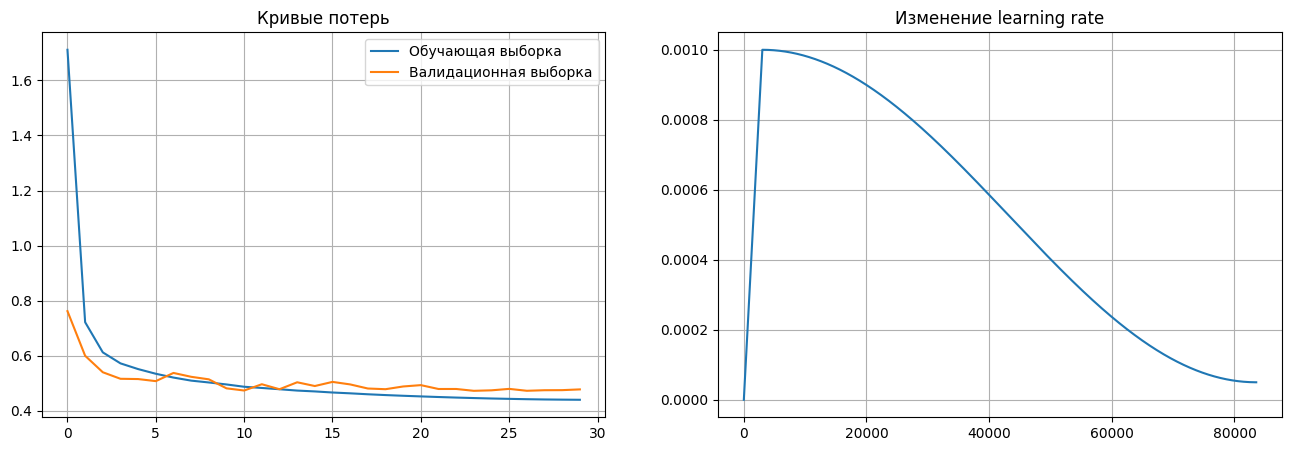

In [ ]:
# Обучим модель
pre_trainer.train()
pre_trainer.visualize()

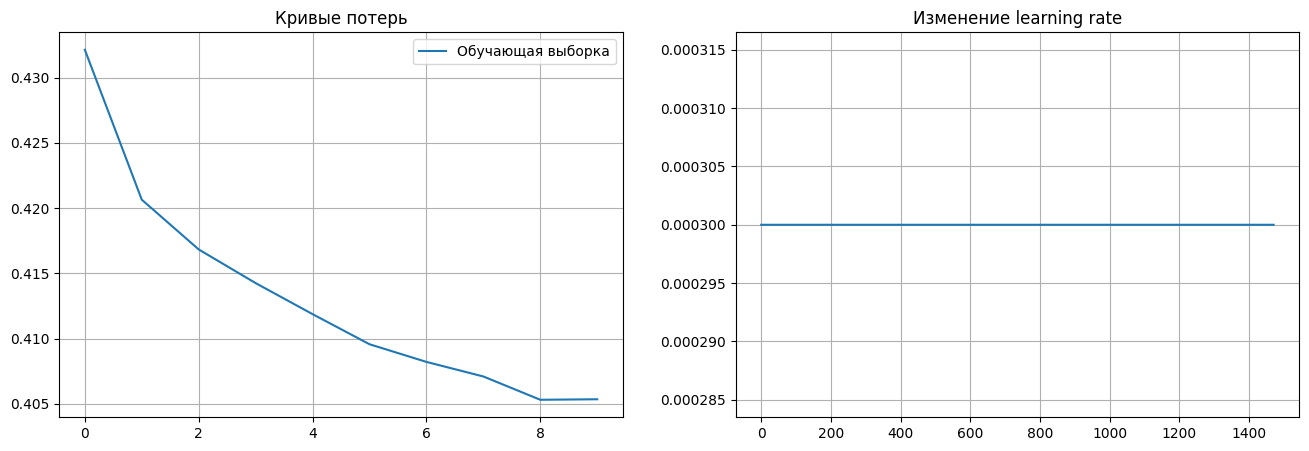

In [ ]:
# Параметры для дообучения
epochs = 10
lr = 3e-4
eta_min = 3e-4
warmup_steps = 0

# Второй тренер модели
post_trainer = Trainer(
    model=rnn_model,
    train=valid_dataset,
    batch_size=batch_size,
    criterion=criterion,
    lr=lr,
    eta_min=eta_min,
    warmup_steps=warmup_steps,
    num_epochs=post_epochs,
    max_norm=max_norm
)

# Дообучим модель
post_trainer.train()
post_trainer.visualize()

In [ ]:
# Предскажем ответы
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=2)
pred = []

rnn_model.eval()
with t.no_grad():
    for X_test in test_loader:
        pred.append(t.clamp(rnn_model(X_test).squeeze(), min=0)[:, -1])

pred = t.hstack(pred)

# Сохраним ответы
submission = pd.read_csv('data/sample_submission.csv')
submission['sales'] = pred

submission.to_csv('data/rnn_submission.csv', index=False)

## Итоговый результат: ##
- RMSLE : __0.43953__ _(≈top 15%)_